In [15]:
# AA228 Orbital Rendezvous – Results & Analysis
# Author: Sabrina Nicacio
# This notebook uses the closed-loop rendezvous simulation from `systems.py`

import numpy as np
import matplotlib.pyplot as plt

from systems import run_closed_loop_episode, CONFIG

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["font.size"] = 12

dt = CONFIG["dt"]
N = CONFIG["N"]
t = np.arange(N + 1) * dt

dock_pos_tol = CONFIG["reward"]["dock_tol_pos"]
dock_vel_tol = CONFIG["reward"]["dock_tol_vel"]

def compute_metrics(res):
    X_true = res["X_true"]          # (N+1, 6)
    rewards = res["rewards"]        # (N,)
    pos_norm = np.linalg.norm(X_true[:, :3], axis=1)
    vel_norm = np.linalg.norm(X_true[:, 3:], axis=1)

    final_dist = pos_norm[-1]
    min_dist = np.min(pos_norm)
    min_dist_step = np.argmin(pos_norm)
    min_dist_time = min_dist_step * dt

    cum_reward = np.cumsum(rewards)
    total_reward = cum_reward[-1]

    # docking condition: within both pos and vel tolerance
    dock_mask = (pos_norm <= dock_pos_tol) & (vel_norm <= dock_vel_tol)
    docked = np.any(dock_mask)
    dock_step = np.where(dock_mask)[0][0] if docked else None
    dock_time = dock_step * dt if docked else None

    return {
        "pos_norm": pos_norm,
        "vel_norm": vel_norm,
        "cum_reward": cum_reward,
        "final_dist": final_dist,
        "min_dist": min_dist,
        "min_dist_time": min_dist_time,
        "total_reward": total_reward,
        "docked": docked,
        "dock_step": dock_step,
        "dock_time": dock_time,
    }

def print_metrics(metrics, title="Episode metrics"):
    print(f"=== {title} ===")
    print(f"Final distance to target: {metrics['final_dist']:.3f} m")
    print(f"Minimum distance to target: {metrics['min_dist']:.3f} m "
          f"(at t = {metrics['min_dist_time']:.1f} s)")
    print(f"Total reward: {metrics['total_reward']:.3f}")
    if metrics["docked"]:
        print(f"Docked: YES at t = {metrics['dock_time']:.1f} s "
              f"(step {metrics['dock_step']})")
    else:
        print("Docked: NO (never simultaneously inside pos & vel tolerances)")
    print()


# run a single "baseline" episode
seed = 42   # can change this and re-run
res = run_closed_loop_episode(seed=seed)

X_true = res["X_true"]
X_hat = res["X_hat"]
actions = res["actions"]
rewards = res["rewards"]

metrics = compute_metrics(res)
print_metrics(metrics, title=f"Episode (seed={seed})")


Created simulation lasting 600.00 sec (10.00 min) with 600 steps
[DEBUG] k=0, x =   50.000 m, u_x = +0.000e+00 m/s^2, x_next =   50.000 m, r =   -0.002
[DEBUG] k=1, x =   50.000 m, u_x = -1.000e-02 m/s^2, x_next =   49.995 m, r =    0.095
[DEBUG] k=2, x =   49.995 m, u_x = +0.000e+00 m/s^2, x_next =   49.986 m, r =    0.191
[DEBUG] k=3, x =   49.986 m, u_x = +0.000e+00 m/s^2, x_next =   49.976 m, r =    0.187
[DEBUG] k=4, x =   49.976 m, u_x = -1.000e-02 m/s^2, x_next =   49.962 m, r =    0.284
[DEBUG] k=5, x =   49.962 m, u_x = +0.000e+00 m/s^2, x_next =   49.943 m, r =    0.380
[DEBUG] k=6, x =   49.943 m, u_x = +0.000e+00 m/s^2, x_next =   49.924 m, r =    0.376
[DEBUG] k=7, x =   49.924 m, u_x = +0.000e+00 m/s^2, x_next =   49.906 m, r =    0.373
[DEBUG] k=8, x =   49.906 m, u_x = +0.000e+00 m/s^2, x_next =   49.887 m, r =    0.369
[DEBUG] k=9, x =   49.887 m, u_x = +0.000e+00 m/s^2, x_next =   49.869 m, r =    0.366
=== Episode (seed=42) ===
Final distance to target: 68.588 m
Mini

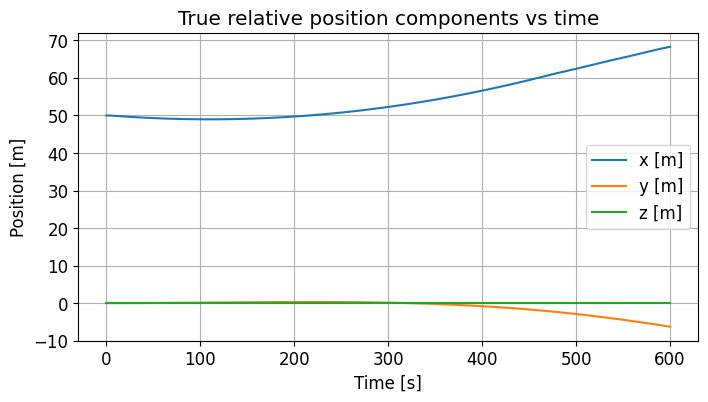

In [16]:
# plot 1 – position components vs time
fig, ax = plt.subplots()
ax.plot(t, X_true[:, 0], label="x [m]")
ax.plot(t, X_true[:, 1], label="y [m]")
ax.plot(t, X_true[:, 2], label="z [m]")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position [m]")
ax.set_title("True relative position components vs time")
ax.legend()
ax.grid(True)
plt.show()

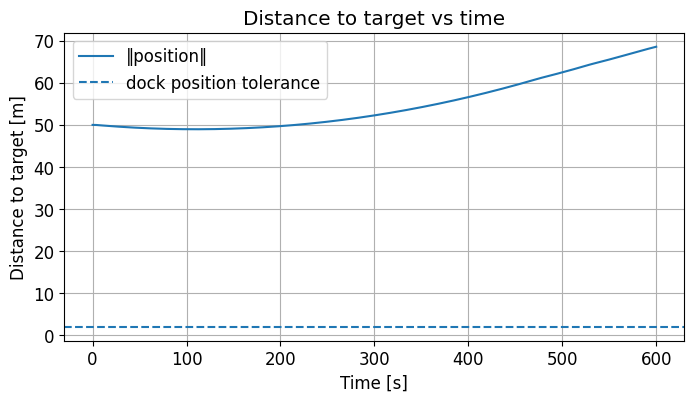

In [17]:
# plot 2 – distance to target vs time (with docking tolerance)
pos_norm = metrics["pos_norm"]

fig, ax = plt.subplots()
ax.plot(t, pos_norm, label="‖position‖")
ax.axhline(dock_pos_tol, linestyle="--", label="dock position tolerance")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Distance to target [m]")
ax.set_title("Distance to target vs time")
ax.legend()
ax.grid(True)
plt.show()

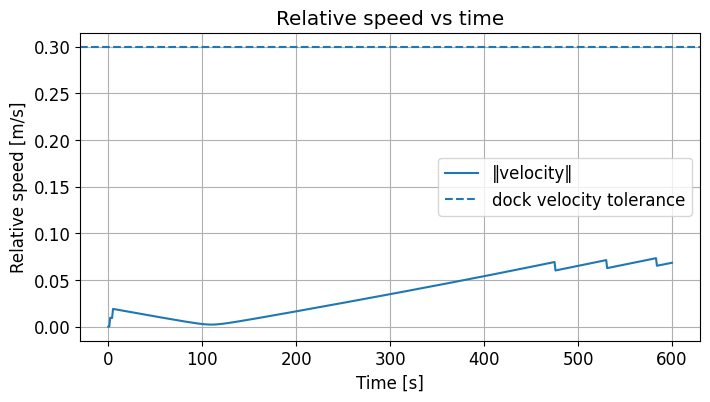

In [18]:
# plot 3 – velocity norm vs time (with docking tolerance)
vel_norm = metrics["vel_norm"]

fig, ax = plt.subplots()
ax.plot(t, vel_norm, label="‖velocity‖")
ax.axhline(dock_vel_tol, linestyle="--", label="dock velocity tolerance")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Relative speed [m/s]")
ax.set_title("Relative speed vs time")
ax.legend()
ax.grid(True)
plt.show()

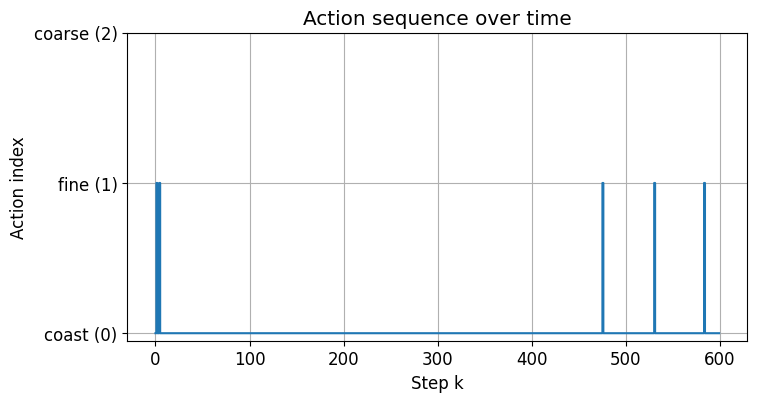

In [19]:
# plot 4 – action sequence vs time
# actions: 0 = coast, 1 = fine thrust, 2 = coarse thrust

fig, ax = plt.subplots()
ax.step(np.arange(len(actions)), actions, where="post")
ax.set_xlabel("Step k")
ax.set_ylabel("Action index")
ax.set_title("Action sequence over time")
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(["coast (0)", "fine (1)", "coarse (2)"])
ax.grid(True)
plt.show()

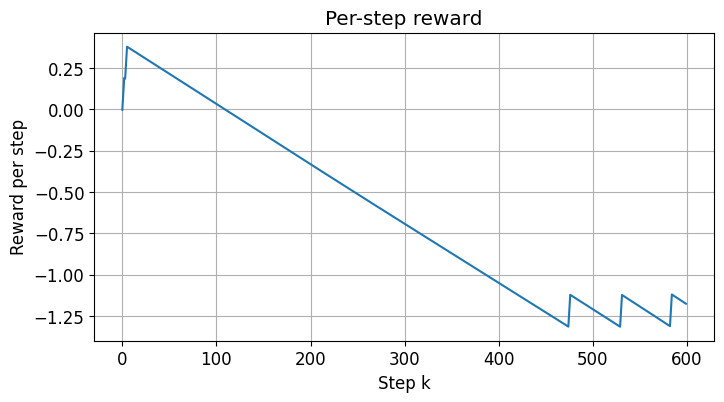

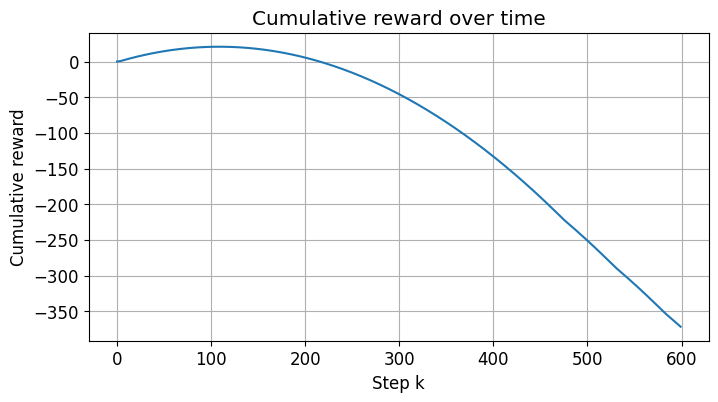

In [20]:
# lot 5 – per-step reward and cumulative reward
cum_reward = metrics["cum_reward"]

fig, ax = plt.subplots()
ax.plot(np.arange(len(rewards)), rewards)
ax.set_xlabel("Step k")
ax.set_ylabel("Reward per step")
ax.set_title("Per-step reward")
ax.grid(True)
plt.show()

fig, ax = plt.subplots()
ax.plot(np.arange(len(cum_reward)), cum_reward)
ax.set_xlabel("Step k")
ax.set_ylabel("Cumulative reward")
ax.set_title("Cumulative reward over time")
ax.grid(True)
plt.show()

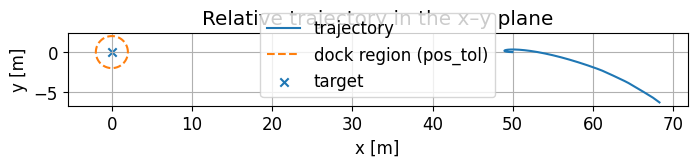

In [21]:
# plot 6 – 2D trajectory in x–y with docking region
fig, ax = plt.subplots()
ax.plot(X_true[:, 0], X_true[:, 1], label="trajectory")

# draw docking circle in x–y plane (z ignored)
theta = np.linspace(0, 2 * np.pi, 200)
ax.plot(dock_pos_tol * np.cos(theta),
        dock_pos_tol * np.sin(theta),
        linestyle="--",
        label="dock region (pos_tol)")

ax.scatter([0.0], [0.0], marker="x", label="target")
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("Relative trajectory in the x–y plane")
ax.legend()
ax.grid(True)
plt.show()

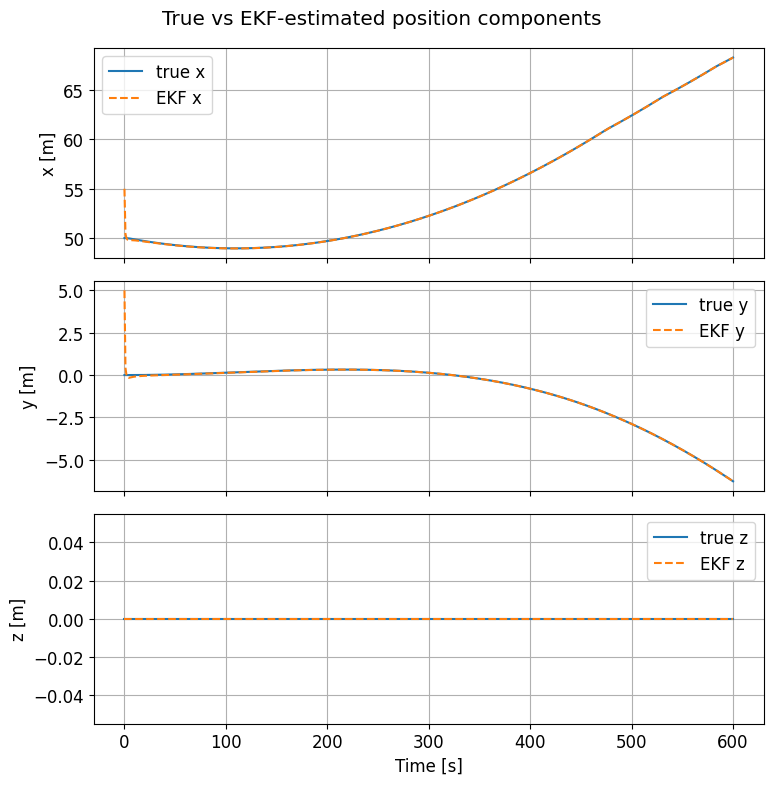

In [22]:
# plot 7 – true vs estimated position (EKF performance)
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

labels = ["x", "y", "z"]
for i in range(3):
    axs[i].plot(t, X_true[:, i], label=f"true {labels[i]}")
    axs[i].plot(t, X_hat[:, i], linestyle="--", label=f"EKF {labels[i]}")
    axs[i].set_ylabel(f"{labels[i]} [m]")
    axs[i].grid(True)
    axs[i].legend()

axs[-1].set_xlabel("Time [s]")
fig.suptitle("True vs EKF-estimated position components")
plt.tight_layout()
plt.show()

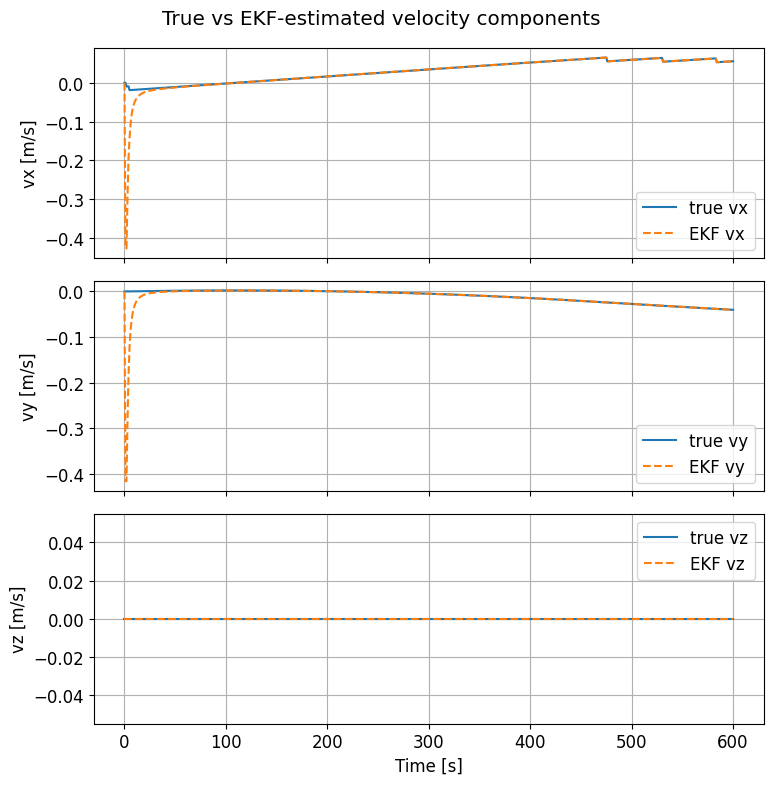

In [23]:
# plot 8 – true vs estimated velocity (EKF performance)
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

labels = ["vx", "vy", "vz"]
for i in range(3):
    axs[i].plot(t, X_true[:, 3 + i], label=f"true {labels[i]}")
    axs[i].plot(t, X_hat[:, 3 + i], linestyle="--", label=f"EKF {labels[i]}")
    axs[i].set_ylabel(f"{labels[i]} [m/s]")
    axs[i].grid(True)
    axs[i].legend()

axs[-1].set_xlabel("Time [s]")
fig.suptitle("True vs EKF-estimated velocity components")
plt.tight_layout()
plt.show()

Created simulation lasting 600.00 sec (10.00 min) with 600 steps
[DEBUG] k=0, x =   50.000 m, u_x = +0.000e+00 m/s^2, x_next =   50.000 m, r =   -0.002
[DEBUG] k=1, x =   50.000 m, u_x = -4.000e-02 m/s^2, x_next =   49.980 m, r =    0.395
[DEBUG] k=2, x =   49.980 m, u_x = +0.000e+00 m/s^2, x_next =   49.941 m, r =    0.791
[DEBUG] k=3, x =   49.941 m, u_x = -1.000e-02 m/s^2, x_next =   49.896 m, r =    0.887
[DEBUG] k=4, x =   49.896 m, u_x = +0.000e+00 m/s^2, x_next =   49.847 m, r =    0.984
[DEBUG] k=5, x =   49.847 m, u_x = +0.000e+00 m/s^2, x_next =   49.798 m, r =    0.980
[DEBUG] k=6, x =   49.798 m, u_x = +0.000e+00 m/s^2, x_next =   49.749 m, r =    0.976
[DEBUG] k=7, x =   49.749 m, u_x = +0.000e+00 m/s^2, x_next =   49.701 m, r =    0.973
[DEBUG] k=8, x =   49.701 m, u_x = +0.000e+00 m/s^2, x_next =   49.652 m, r =    0.969
[DEBUG] k=9, x =   49.652 m, u_x = +0.000e+00 m/s^2, x_next =   49.604 m, r =    0.965
Created simulation lasting 600.00 sec (10.00 min) with 600 steps


KeyboardInterrupt: 

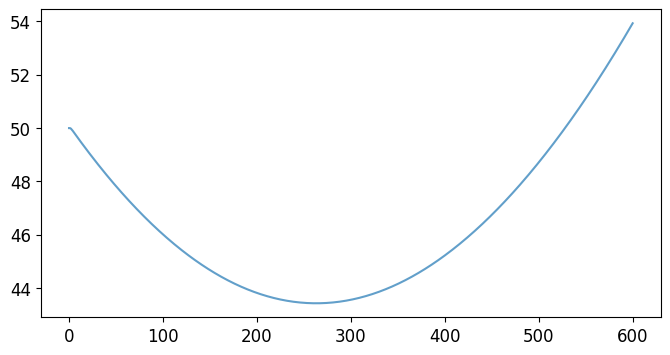

In [24]:
# experiment – run multiple seeds and compare
num_seeds = 5
seed_list = list(range(42, 42 + num_seeds))

all_metrics = []

for sd in seed_list:
    res_sd = run_closed_loop_episode(seed=sd)
    m_sd = compute_metrics(res_sd)
    all_metrics.append(m_sd)

    # plot distance traces as "spaghetti" to show variability
    plt.plot(t, m_sd["pos_norm"], alpha=0.7, label=f"seed {sd}")

plt.axhline(dock_pos_tol, linestyle="--", label="dock pos tol")
plt.xlabel("Time [s]")
plt.ylabel("Distance to target [m]")
plt.title("Distance vs time for multiple seeds")
plt.legend()
plt.grid(True)
plt.show()

# print a small table of summary metrics
print("=== Summary over multiple seeds ===")
for sd, m_sd in zip(seed_list, all_metrics):
    print(f"Seed {sd}: final_dist = {m_sd['final_dist']:.2f} m, "
          f"min_dist = {m_sd['min_dist']:.2f} m, "
          f"total_reward = {m_sd['total_reward']:.1f}, "
          f"docked = {m_sd['docked']}")